### Optical character recognition using RNNs

In [97]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [98]:
import os
import gzip
import csv

In [99]:
import numpy as np
import tensorflow as tf

In [100]:
from six.moves import urllib

In [101]:
URL_PATH = 'http://ai.stanford.edu/~btaskar/ocr/letter.data.gz'
DOWNLOADED_FILENAME = 'letter.data.gz'

def download_data():
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(URL_PATH, DOWNLOADED_FILENAME)
    
    print ('Found and verified file from this path: ', URL_PATH)
    print ('Downloaded file: ', DOWNLOADED_FILENAME)

In [102]:
download_data()

Found and verified file from this path:  http://ai.stanford.edu/~btaskar/ocr/letter.data.gz
Downloaded file:  letter.data.gz


In [103]:
def read_lines():
    with gzip.open(DOWNLOADED_FILENAME, 'rt') as f:
        reader = csv.reader(f, delimiter='\t')
        lines = list(reader)
        return lines

In [104]:
lines = read_lines()

In [105]:
lines[1][:20]

['2',
 'm',
 '3',
 '1',
 '2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0']

In [106]:
len(lines)

52152

In [107]:
def get_features_labels(lines):
    lines = sorted(lines, key=lambda x: int(x[0]))
    data, target = [], []
    
    next_id = -1
    
    word = []
    word_pixels = []

    for line in lines:
         # The index for the next_id column
        next_id = int(line[2])

        # An image for a single character, reshaped
        pixels = np.array([int(x) for x in line[6:134]])
        pixels = pixels.reshape((16, 8))
        
        # Word pixels are a list of 16x8 images which form a single word
        word_pixels.append(pixels)
        
        # Append together the characters which make up a word
        word.append(line[1])
        
        if next_id == -1:
            data.append(word_pixels)
            target.append(word) 
            word = []
            word_pixels = []


    return data, target

In [108]:
data, target = get_features_labels(lines)

#### The total number of words in our dataset

In [109]:
len(data), len(target)

(6877, 6877)

#### All words lengths should be the same

* Get every word to be the same length as the longest word in our dataset
* Pad the words with empty characters

In [110]:
def pad_features_labels(data, target):    
    max_length = max(len(x) for x in target)
    
    # Set up image representations for the empty string (all pixels set to 0)
    padding = np.zeros((16, 8))

    # Pad the image data with the empty string images
    data = [x + ([padding] * (max_length - len(x))) for x in data]
    
    # Pad the words with empty string characters
    target = [x + ([''] * (max_length - len(x))) for x in target]
    
    return np.array(data), np.array(target)

In [111]:
padded_data, padded_target = pad_features_labels(data, target)

In [112]:
padded_target[:10]

array([['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', ''],
       ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g', '', '', '', '', '']],
      dtype='<U1')

In [113]:
padded_target[200:210]

array([['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', ''],
       ['m', 'b', 'r', 'a', 'c', 'e', 's', '', '', '', '', '', '', '']],
      dtype='<U1')

#### The length of each sequence

We've padded all words so that their lengths are all equal to the length of the longest word

In [114]:
word_length = len(padded_target[0])

In [115]:
word_length

14

#### Tensor shape

* 6877 words
* Each word padded to have 14 characters
* Each character represented by 16x8 image

In [116]:
padded_data.shape

(6877, 14, 16, 8)

In [117]:
padded_data.shape[:2] + (-1,)

(6877, 14, -1)

In [118]:
reshaped_data = padded_data.reshape(padded_data.shape[:2] + (-1,))

#### Reshape the data so the image is a 1-D array of pixels

In [119]:
reshaped_data.shape

(6877, 14, 128)

#### Tensor shape

* 6877 words
* Each an array with 14 characters (padded with empty strings as needed)

In [120]:
padded_target.shape

(6877, 14)

#### One-hot representation

* Each character has a feature vector of 26 (only lower case characters)

In [121]:
padded_target.shape + (26,)

(6877, 14, 26)

In [122]:
one_hot_target = np.zeros(padded_target.shape + (26,))

### Numpy.ndenumerate is a way to get all indices needed to access elements of a matrix
<pre>
a = numpy.array([[1,2],[3,4],[5,6]])
for (x,y), value in numpy.ndenumerate(a):
  print x,y 
</pre>
 
0 0 <br>
0 1 <br>
1 0 <br>
1 1 <br>
2 0 <br>
2 1 <br>

In [123]:
for index, letter in np.ndenumerate(padded_target):
    if letter:
        one_hot_target[index][ord(letter) - ord('a')] = 1

#### One-hot representation of the letter 'o'

* The letter 'o' represented by a 1 at the 14th index 
* Index positions start at 0

In [124]:
one_hot_target[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [125]:
shuffled_indices = np.random.permutation(len(reshaped_data))

shuffled_data = reshaped_data[shuffled_indices]
shuffled_target = one_hot_target[shuffled_indices]

#### Split into training and test data

In [126]:
split = int(0.66 * len(shuffled_data))

train_data = shuffled_data[:split]
train_target = shuffled_target[:split]

test_data = shuffled_data[split:]
test_target = shuffled_target[split:]

In [127]:
train_data.shape

(4538, 14, 128)

In [128]:
_, num_steps, num_inputs = train_data.shape

In [129]:
train_target.shape

(4538, 14, 26)

In [130]:
num_classes = train_target.shape[2]

In [131]:
tf.reset_default_graph()

In [132]:
X = tf.placeholder(tf.float64, [None, num_steps, num_inputs])

y = tf.placeholder(tf.float64, [None, num_steps, num_classes])

#### Sequence length calculation

*['How', 'are', 'you', 'doing'] ==> [14, 14, 14, 14] ==> [3, 3, 3, 5]*
 
 The actual length of each word (without the padding) in the input batch

In [133]:
# All real characters will have a max value of 1, padded characters will be represented by 0s
used = tf.sign(tf.reduce_max(tf.abs(X), reduction_indices=2))

# Sum up the number of real characters for each word
length = tf.reduce_sum(used, reduction_indices=1)
sequence_length = tf.cast(length, tf.int32)

In [134]:
sequence_length

<tf.Tensor 'Cast:0' shape=(?,) dtype=int32>

#### RNN for training and prediction

In [135]:
num_neurons = 300

In [136]:
cell = tf.nn.rnn_cell.GRUCell(num_neurons)

#### *sequence_length* is the length of the valid input for each batch

Included to improve accuracy and not for performance

In [137]:
output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float64, sequence_length=sequence_length)

In [138]:
output.shape

TensorShape([Dimension(None), Dimension(14), Dimension(300)])

#### Shared softmax layer

In [139]:
weight = tf.Variable(tf.truncated_normal([num_neurons, num_classes], stddev=0.01, dtype=tf.float64))

In [140]:
bias = tf.Variable(tf.constant(0.1, shape=[num_classes], dtype=tf.float64))

In [141]:
flattened_output = tf.reshape(output, [-1, num_neurons])

In [142]:
flattened_output

<tf.Tensor 'Reshape:0' shape=(?, 300) dtype=float64>

In [143]:
logits = tf.matmul(flattened_output, weight) + bias

In [144]:
logits_reshaped = tf.reshape(logits, [-1, num_steps, num_classes])

#### Cost calculation

In [145]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)

In [146]:
loss = tf.reduce_mean(cross_entropy)

#### Error calculation

* For every word calculate how many of the characters we predicted correctly
* Use the mask to not consider (leave out) the padded characters on which our prediction was wrong
* Find the fraction of each word where we made mistakes in our character prediction
* Find the average fraction of each word that were mistakes

In [147]:
mistakes = tf.not_equal(
            tf.argmax(y, 2), tf.argmax(logits_reshaped, 2))
mistakes = tf.cast(mistakes, tf.float64)
mask = tf.sign(tf.reduce_max(tf.abs(y), reduction_indices=2))
mistakes *= mask

In [148]:
mistakes = tf.reduce_sum(mistakes, reduction_indices=1)
mistakes /= tf.cast(sequence_length, tf.float64)

In [149]:
error = tf.reduce_mean(mistakes)

#### Optimizer

In [150]:
optimizer = tf.train.RMSPropOptimizer(0.002)

In [151]:
gradient = optimizer.compute_gradients(loss)

In [152]:
optimize = optimizer.apply_gradients(gradient)

In [153]:
def batched(data, target, batch_size):
    epoch = 0
    offset = 0
    while True:
        old_offset = offset
        offset = (offset + batch_size) % (target.shape[0] - batch_size)

        # Offset wrapped around to the beginning so new epoch
        if offset < old_offset:
            # New epoch, need to shuffle data
            shuffled_indices = np.random.permutation(len(data))
            
            data = data[shuffled_indices]
            target = target[shuffled_indices]

            epoch += 1

        batch_data = data[offset:(offset + batch_size), :]
        
        batch_target = target[offset:(offset + batch_size), :]

        yield batch_data, batch_target, epoch

In [154]:
batch_size = 20
batches = batched(train_data, train_target, batch_size)

In [155]:
epochs = 5

In [156]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    trials_no = []
    error_list = []
    for index, batch in enumerate(batches):
        batch_data = batch[0]
        batch_target = batch[1]
    
        epoch = batch[2]

        if epoch >= epochs:
            break
        
        feed = {X: batch_data, y: batch_target}
        train_error, _ = sess.run([error, optimize], feed)
        
        print('{}: {:3.6f}%'.format(index + 1, 100 * train_error))
        trials_no.append(index+1)
        error_list.append(100*train_error)

    test_feed = {X: test_data, y: test_target}
    test_error, _ = sess.run([error, optimize], test_feed)
    
    print('Test error: {:3.6f}%'.format(100 * test_error))

1: 96.305556%
2: 96.984127%
3: 97.392857%
4: 98.541667%
5: 96.706349%
6: 97.619048%
7: 97.277778%
8: 99.545455%
9: 99.615385%
10: 96.751623%
11: 98.050214%
12: 96.420635%
13: 98.706294%
14: 96.809524%
15: 98.666667%
16: 96.875000%
17: 95.771825%
18: 98.444444%
19: 99.115385%
20: 95.536325%
21: 93.721154%
22: 93.847527%
23: 98.071429%
24: 95.476190%
25: 95.444444%
26: 97.355284%
27: 97.446553%
28: 93.176532%
29: 94.220058%
30: 95.416972%
31: 94.694264%
32: 94.326313%
33: 94.176407%
34: 94.755772%
35: 95.849206%
36: 93.825341%
37: 93.986541%
38: 92.924603%
39: 91.742063%
40: 93.452381%
41: 91.764624%
42: 93.191087%
43: 92.287698%
44: 93.128968%
45: 91.049728%
46: 85.917222%
47: 91.104978%
48: 86.887210%
49: 91.395091%
50: 90.152597%
51: 97.714286%
52: 88.405067%
53: 84.684898%
54: 88.379995%
55: 92.606602%
56: 82.838467%
57: 82.462302%
58: 88.480159%
59: 88.514319%
60: 86.799603%
61: 89.907967%
62: 89.053030%
63: 89.036325%
64: 89.428877%
65: 89.207917%
66: 87.740995%
67: 92.021590%
68: 

527: 10.737179%
528: 4.172009%
529: 8.269841%
530: 7.173993%
531: 3.713980%
532: 13.760032%
533: 17.353591%
534: 4.333333%
535: 7.361111%
536: 7.055556%
537: 2.051282%
538: 6.317460%
539: 4.557110%
540: 3.847222%
541: 5.027778%
542: 10.539683%
543: 9.773810%
544: 9.954365%
545: 9.958333%
546: 8.214286%
547: 11.525794%
548: 6.434524%
549: 5.908425%
550: 6.571429%
551: 4.126984%
552: 14.641414%
553: 11.166667%
554: 6.805556%
555: 8.686203%
556: 11.119048%
557: 10.970238%
558: 4.492063%
559: 8.214161%
560: 5.172619%
561: 2.884615%
562: 6.010101%
563: 8.051282%
564: 5.380952%
565: 5.495726%
566: 11.577381%
567: 3.377040%
568: 7.597222%
569: 12.857143%
570: 4.007937%
571: 4.513889%
572: 12.486472%
573: 2.880952%
574: 4.279942%
575: 4.484127%
576: 4.483516%
577: 10.500000%
578: 10.447677%
579: 10.218254%
580: 5.650794%
581: 5.335859%
582: 10.218254%
583: 14.936508%
584: 9.759615%
585: 7.411131%
586: 9.599567%
587: 14.948593%
588: 4.631369%
589: 5.571123%
590: 11.334402%
591: 9.975580%
592: 1

1065: 4.829060%
1066: 2.430556%
1067: 4.458333%
1068: 3.895022%
1069: 2.606838%
1070: 2.606838%
1071: 1.714286%
1072: 4.845113%
1073: 3.761905%
1074: 3.380952%
1075: 4.333333%
1076: 0.000000%
1077: 1.357143%
1078: 1.547619%
1079: 2.083333%
1080: 8.777778%
1081: 4.206349%
1082: 2.222222%
1083: 2.061688%
1084: 2.606838%
1085: 4.787879%
1086: 0.000000%
1087: 5.569444%
1088: 0.741758%
1089: 2.166667%
1090: 1.250000%
1091: 2.666667%
1092: 7.321429%
1093: 4.672619%
1094: 6.138889%
1095: 6.225941%
1096: 8.888889%
1097: 1.773810%
1098: 0.833333%
1099: 3.416667%
1100: 5.103175%
1101: 4.700092%
1102: 0.714286%
1103: 1.654457%
1104: 1.055556%
1105: 7.009615%
1106: 5.517857%
1107: 0.801282%
1108: 4.055556%
1109: 7.130647%
1110: 5.390443%
1111: 1.000000%
1112: 7.364469%
1113: 7.141053%
1114: 7.678571%
1115: 1.537698%
1116: 5.555556%
1117: 5.106838%
1118: 2.135101%
1119: 8.819444%
1120: 3.125000%
1121: 5.148810%
1122: 1.324786%
1123: 7.204545%
1124: 3.265568%
1125: 4.756313%
1126: 9.236111%
1127: 3.

** Test error rate for Conventional RNNs**

The average test error in case of Conventional Recurrent Neural Network is **7.199088%**


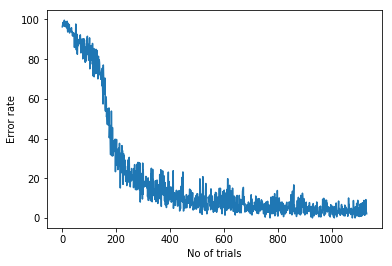

In [157]:
import matplotlib.pyplot as plt
plt.xlabel('No of trials')
plt.ylabel('Error rate')
plt.plot(trials_no, error_list)

## Bi-directional RNN

In [158]:
new_output, _ = tf.nn.bidirectional_dynamic_rnn(tf.nn.rnn_cell.GRUCell(num_neurons), 
                                            tf.nn.rnn_cell.GRUCell(num_neurons),
                                            X,
                                            dtype=tf.float64, sequence_length=sequence_length)

In [159]:
new_output

(<tf.Tensor 'bidirectional_rnn/fw/fw/transpose_1:0' shape=(?, 14, 300) dtype=float64>,
 <tf.Tensor 'ReverseSequence:0' shape=(?, 14, 300) dtype=float64>)

In [160]:
new_output = tf.concat([new_output[0], new_output[1]], axis=2)

In [161]:
new_output.shape

TensorShape([Dimension(None), Dimension(14), Dimension(600)])

In [162]:
new_weight = tf.Variable(tf.truncated_normal([num_neurons * 2, num_classes], stddev=0.01, dtype=tf.float64))

In [163]:
new_bias = tf.Variable(tf.constant(0.1, shape=[num_classes], dtype=tf.float64))

In [164]:
new_flattened_output = tf.reshape(new_output, [-1, num_neurons * 2])

In [165]:
new_flattened_output

<tf.Tensor 'Reshape_2:0' shape=(?, 600) dtype=float64>

In [166]:
new_logits = tf.matmul(new_flattened_output, new_weight) + new_bias

In [167]:
new_logits_reshaped = tf.reshape(new_logits, [-1, num_steps, num_classes])

In [168]:
new_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=new_logits, labels=y)

In [169]:
new_loss = tf.reduce_mean(new_cross_entropy)

In [170]:
new_mistakes = tf.not_equal(
            tf.argmax(y, 2), tf.argmax(new_logits_reshaped, 2))
new_mistakes = tf.cast(new_mistakes, tf.float64)
new_mask = tf.sign(tf.reduce_max(tf.abs(y), reduction_indices=2))
new_mistakes *= new_mask

In [171]:
new_mistakes = tf.reduce_sum(new_mistakes, reduction_indices=1)
new_mistakes /= tf.cast(sequence_length, tf.float64)

In [172]:
new_error = tf.reduce_mean(new_mistakes)

In [173]:
new_optimizer = tf.train.RMSPropOptimizer(0.002)

In [174]:
new_gradient = new_optimizer.compute_gradients(new_loss)

In [175]:
new_optimize = new_optimizer.apply_gradients(new_gradient)

In [176]:
new_batch_size = 10
new_batches = batched(train_data, train_target, batch_size)

In [177]:
epochs = 5

In [178]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    new_trials_no = []
    new_error_list = []
    
    for index, batch in enumerate(new_batches):
        batch_data = batch[0]
        batch_target = batch[1]
    
        epoch = batch[2]

        if epoch >= epochs:
            break
        
        feed = {X: batch_data, y: batch_target}
        train_error, _ = sess.run([new_error, new_optimize], feed)
        
        print('{}: {:3.6f}%'.format(index + 1, 100 * train_error))
        new_trials_no.append(index+1)
        new_error_list.append(100*train_error)
        
    test_feed = {X: test_data, y: test_target}
    test_error, _ = sess.run([new_error, new_optimize], test_feed)
    
    print('Test error: {:3.6f}%'.format(100 * test_error))

1: 93.726496%
2: 94.121101%
3: 95.670635%
4: 97.127595%
5: 97.821068%
6: 95.142857%
7: 95.893162%
8: 94.412463%
9: 97.997835%
10: 96.285714%
11: 96.160714%
12: 93.785714%
13: 94.182359%
14: 96.920635%
15: 96.861111%
16: 91.063492%
17: 96.817890%
18: 95.438492%
19: 93.418415%
20: 94.740385%
21: 96.192460%
22: 95.224331%
23: 93.047619%
24: 92.616883%
25: 93.795940%
26: 94.005717%
27: 91.037463%
28: 90.861361%
29: 88.747294%
30: 90.990079%
31: 95.142496%
32: 85.059829%
33: 86.896465%
34: 89.060967%
35: 86.501984%
36: 87.426351%
37: 86.009324%
38: 91.250000%
39: 89.732143%
40: 88.079365%
41: 88.329795%
42: 89.632937%
43: 88.712302%
44: 86.845238%
45: 89.881022%
46: 82.715909%
47: 88.330628%
48: 88.097777%
49: 90.616522%
50: 86.539141%
51: 90.181166%
52: 90.536020%
53: 88.528513%
54: 84.615385%
55: 84.981061%
56: 89.531996%
57: 79.769841%
58: 86.591270%
59: 89.780497%
60: 83.119048%
61: 87.824023%
62: 90.942280%
63: 89.006258%
64: 92.062424%
65: 88.693848%
66: 87.836538%
67: 93.025863%
68: 

533: 3.333333%
534: 0.833333%
535: 0.000000%
536: 1.250000%
537: 4.815476%
538: 3.571429%
539: 3.333333%
540: 2.166667%
541: 0.416667%
542: 0.416667%
543: 8.787879%
544: 3.333333%
545: 0.625000%
546: 5.833333%
547: 0.416667%
548: 0.555556%
549: 2.658730%
550: 0.000000%
551: 8.047619%
552: 4.172009%
553: 0.555556%
554: 1.269841%
555: 0.000000%
556: 7.916667%
557: 2.222222%
558: 1.666667%
559: 4.340659%
560: 3.333333%
561: 3.373016%
562: 0.625000%
563: 1.666667%
564: 0.555556%
565: 7.454545%
566: 3.958333%
567: 6.666667%
568: 0.000000%
569: 0.714286%
570: 10.555556%
571: 8.000000%
572: 0.555556%
573: 5.333333%
574: 0.000000%
575: 0.000000%
576: 0.000000%
577: 0.000000%
578: 2.329545%
579: 1.000000%
580: 2.291667%
581: 4.105339%
582: 3.958333%
583: 2.936508%
584: 2.222222%
585: 6.585498%
586: 1.190476%
587: 2.625000%
588: 0.000000%
589: 0.000000%
590: 1.666667%
591: 5.714286%
592: 1.079545%
593: 5.833333%
594: 5.000000%
595: 1.217949%
596: 1.041667%
597: 4.000000%
598: 1.988636%
599: 2.94

1076: 0.000000%
1077: 0.714286%
1078: 0.000000%
1079: 0.000000%
1080: 1.666667%
1081: 5.000000%
1082: 0.000000%
1083: 0.000000%
1084: 0.000000%
1085: 0.000000%
1086: 0.000000%
1087: 0.555556%
1088: 0.000000%
1089: 0.000000%
1090: 0.000000%
1091: 3.333333%
1092: 0.000000%
1093: 0.625000%
1094: 0.000000%
1095: 0.000000%
1096: 0.000000%
1097: 0.555556%
1098: 0.000000%
1099: 0.000000%
1100: 0.000000%
1101: 0.000000%
1102: 0.000000%
1103: 0.000000%
1104: 0.000000%
1105: 0.000000%
1106: 0.000000%
1107: 0.384615%
1108: 0.000000%
1109: 0.000000%
1110: 0.000000%
1111: 0.000000%
1112: 1.666667%
1113: 0.000000%
1114: 0.833333%
1115: 0.833333%
1116: 0.000000%
1117: 0.000000%
1118: 2.103175%
1119: 0.000000%
1120: 1.875000%
1121: 0.000000%
1122: 0.000000%
1123: 0.000000%
1124: 3.333333%
1125: 0.000000%
1126: 0.000000%
1127: 0.833333%
1128: 0.000000%
1129: 0.000000%
Test error: 2.439806%


** Test error rate for Bidirectional RNNs**

The average test error in case of Conventional Recurrent Neural Network is **2.439806%**

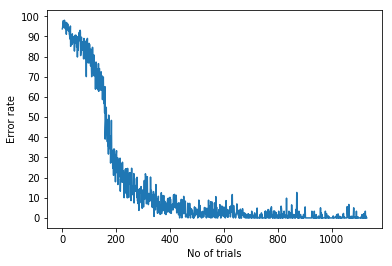

In [182]:
import matplotlib.pyplot as plt
plt.yticks(np.arange(0, max(new_trials_no), step=10))
plt.xlabel('No of trials')
plt.ylabel('Error rate')
plt.plot(new_trials_no, new_error_list)